In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from PIL import Image
import tifffile
import napari
from matplotlib import pyplot as plt

In [ ]:
from scribbles_testing.FoodSeg103_data_handler import load_food_batch, load_food_data
from scribbles_testing.convpaint_helpers import generate_convpaint_tag
from scribbles_testing.image_analysis_helpers import single_img_stats
from scribbles_creator import create_even_scribbles
from seghub.vgg16_utils import get_vgg16_features_targets, get_vgg16_feature_space
from seghub.dino_utils import get_dinov2_patch_features, get_dinov2_pixel_features, get_dinov2_features_targets, get_dinov2_feature_space
from seghub.ilastik_utils import get_ila_features_targets, get_ila_feature_space
from seghub.rf_utils import train_segforest, predict_segforest_single_image, predict_segforest, selfpredict_segforest_single_image
from seghub.classif_utils import features_combinator

## Tests on a single image

In [15]:
img, gt = load_food_data(0)
img = img/255
print(img.shape, gt.shape)
print(img.min(), img.max(), np.unique(gt))

(384, 512, 3) (384, 512)
0.0 1.0 [ 1 49 67 91]


In [36]:
nap_v = napari.view_image(img)
nap_v.add_labels(gt)

<Labels layer 'gt' at 0x26610511610>

Now you can add a "labels" layer in the viewer, add labels, and then assign them to the labels variable used for the predictions

In [18]:
# labels = nap_v.layers['Labels'].data
# labels2 = nap_v.layers['Labels copy'].data

In [28]:
vgg16_cfg = {"layer_list": [0], 
             "scalings": [1,2],
             "rgb_if_possible": True}
dinov2_cfg = {"dinov2_model":"s_r",
              "interpolate_features": False}

feature_funcs = [get_vgg16_feature_space, get_dinov2_feature_space]
feature_cfgs = [vgg16_cfg, dinov2_cfg]

combinator_cfg = {"features_func_list":feature_funcs, "features_cfg_list":feature_cfgs,
                  "num_pcs_list":None, "feature_smoothness_list":None, "img_as_feature":False}

In [ ]:
pred_combo_loose = selfpredict_segforest_single_image(img, labels, features_combinator, combinator_cfg, random_state=0)
pred_vgg16 = selfpredict_segforest_single_image(img, labels2, get_vgg16_feature_space, vgg16_cfg, random_state=0)
pred_dino = selfpredict_segforest_single_image(img, labels2, get_dinov2_feature_space, dinov2_cfg, random_state=0)
pred_combo = selfpredict_segforest_single_image(img, labels2, features_combinator, combinator_cfg, random_state=0)
pred_combo_smooth = selfpredict_segforest_single_image(img, labels2, features_combinator, combinator_cfg, random_state=0, pred_smoothness=4)

In [37]:
nap_v.add_labels(pred_combo_loose)
nap_v.add_labels(pred_vgg16)
nap_v.add_labels(pred_dino)
nap_v.add_labels(pred_combo)
nap_v.add_labels(pred_combo_smooth)

<Labels layer 'pred_combo_smooth' at 0x26631d96b50>

In [38]:
nap_v.add_labels(labels, name='Labels loose')
nap_v.add_labels(labels2, name='Labels tight')

<Labels layer 'Labels tight' at 0x266320fad00>

In [21]:
# tifffile.imwrite("24-07-15_food_combo-vs-dsr_labelling-comparison_labels-loose.tif", labels)
# tifffile.imwrite("24-07-15_food_combo-vs-dsr_labelling-comparison_labels-tight.tif", labels2)

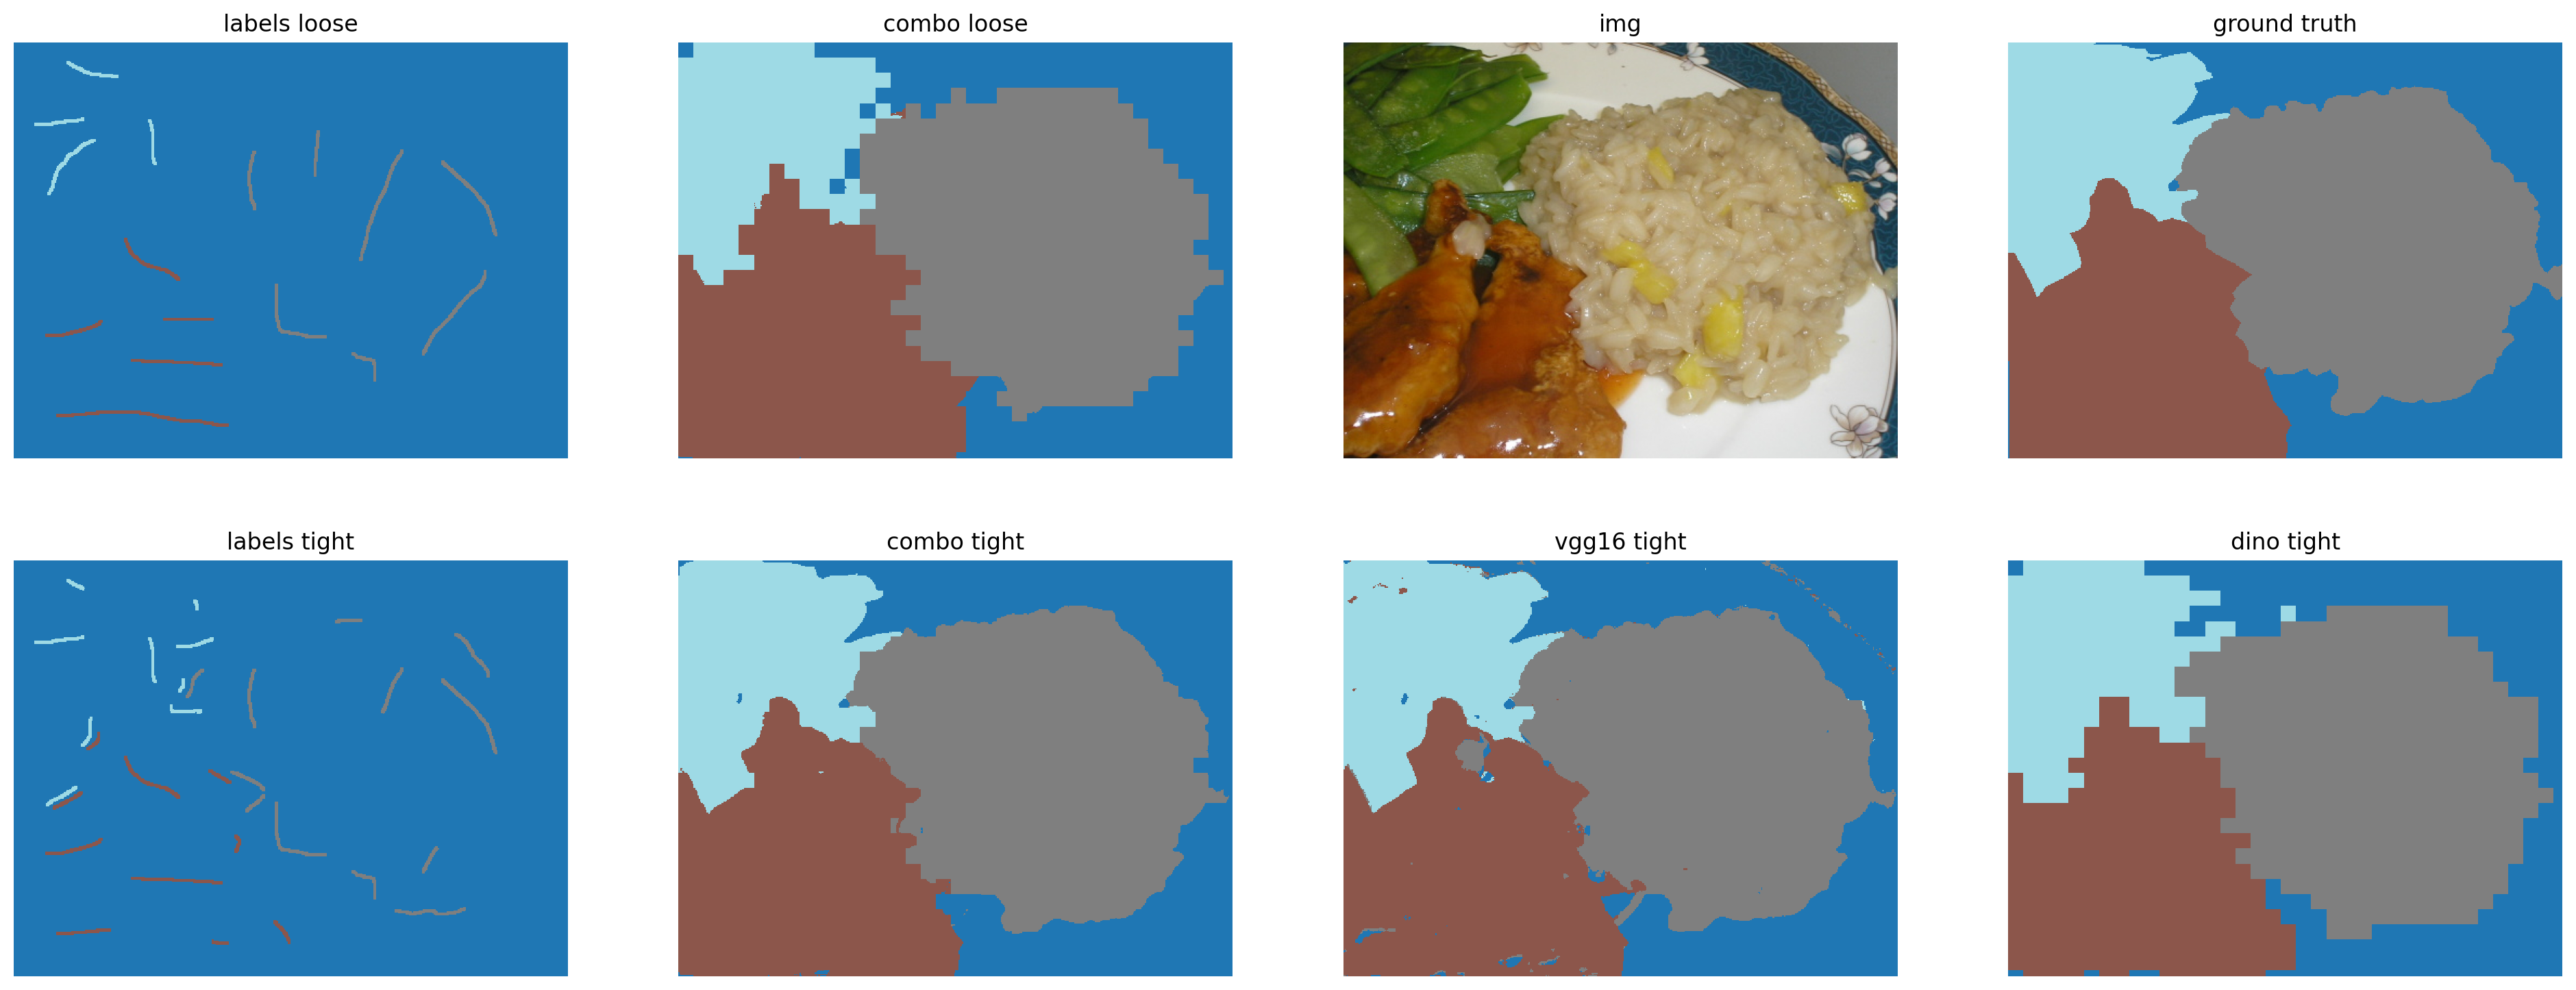

In [49]:
plt_cfg = {"interpolation":"none", "cmap":"tab20"}
fig, ax = plt.subplots(2, 4, figsize=(24,9), dpi=200)
ax[0,2].imshow(img)
ax[0,3].imshow(gt, **plt_cfg)
ax[0,0].imshow(labels, **plt_cfg)
ax[1,0].imshow(labels2, **plt_cfg)
ax[0,1].imshow(pred_combo_loose, **plt_cfg)
ax[1,1].imshow(pred_combo, **plt_cfg)
ax[1,2].imshow(pred_vgg16, **plt_cfg)
ax[1,3].imshow(pred_dino, **plt_cfg)

for i, t in enumerate(["labels loose", "combo loose", "img", "ground truth", "labels tight", "combo tight", "vgg16 tight", "dino tight"]):
    ax.flatten()[i].set_title(t)
    ax.flatten()[i].axis('off')

plt.savefig("24-07-15_food_combo-vs-dsr_labelling-comparison_c.png", dpi=300)

# plt_cfg = {"interpolation":"none", "cmap":"tab20"}
# fig, ax = plt.subplots(4, 2, figsize=(10,15))
# ax[0,0].imshow(img)
# ax[0,1].imshow(gt, **plt_cfg)
# ax[1,0].imshow(labels, **plt_cfg)
# ax[1,1].imshow(labels2, **plt_cfg)
# ax[2,0].imshow(pred_combo_loose, **plt_cfg)
# ax[2,1].imshow(pred_combo, **plt_cfg)
# ax[3,0].imshow(pred_vgg16, **plt_cfg)
# ax[3,1].imshow(pred_dino, **plt_cfg)

## Tests on image batches

In [3]:
img_nums = [n for n in range(0, 4500, 200)] #2750 #1234 #2314
imgs, gts = load_food_batch(img_nums, load_gts=True)
num_imgs = len(imgs)
print(f"Total images: {num_imgs}")

Total images: 23


In [4]:
resol = {im_num: np.prod(im.shape[:2]) for im_num, im in imgs.items()}

# Check for images with resolution over a certain threshold
thresh = 640_000
imgs = {im_num: im for im_num, im in imgs.items() if resol[im_num] <= thresh}
gts = {im_num: im for im_num, im in gts.items() if resol[im_num] <= thresh}
for im_num, img in imgs.items(): print(f"{im_num:4d}: {np.prod(img.shape[:2]):7,d} pixels")
print(f"Total images: {len(imgs)}")

   0: 196,608 pixels
 200: 196,608 pixels
 400: 196,608 pixels
 600:  65,536 pixels
 800: 262,144 pixels
1000: 196,608 pixels
1200:  65,536 pixels
1600: 273,920 pixels
1800: 196,608 pixels
2000: 172,544 pixels
2200: 196,608 pixels
2400: 252,970 pixels
2600: 614,400 pixels
2800: 196,608 pixels
3000: 174,080 pixels
3400: 196,608 pixels
3600: 196,608 pixels
3800: 250,920 pixels
4000: 196,608 pixels
4200: 174,592 pixels
4400: 196,608 pixels
Total images: 21


In [28]:
# CELLPOSE
data_path = "../cellpose_train_imgs/"
imgs = {im_num: np.array(Image.open(data_path + str(im_num).zfill(3) + "_img.png")) for im_num in range(0, 540, 40)}

In [32]:
gts = {im_num: np.array(Image.open(data_path + str(im_num).zfill(3) + "_ground_truth.png")) for im_num in imgs.keys()}

In [49]:
# Which scribbles to use
mode = "all"
bin = 0.5
enforce_max_perc = True
rel_scribble_len = 10
scribble_width = 2

scribbles_seed = 1

# Which prediction models to use
vgg16_cfg = {"layer_list": [0,2], 
                "scalings": [1,2,4,8],
                "rgb_if_possible": True}

pred_tag = generate_convpaint_tag(vgg16_cfg["layer_list"], vgg16_cfg["scalings"])

pred_seed = 123

In [50]:
feature_funcs = [get_vgg16_feature_space, get_dinov2_feature_space]
feature_cfgs = [{"layer_list":vgg16_cfg["layer_list"], "scalings":vgg16_cfg["scalings"]},
                 {"interpolate_features":False, "dinov2_model":"s_r"}]

combinator_cfg = {"features_func_list":feature_funcs, "features_cfg_list":feature_cfgs,
                  "num_pcs_list":None, "feature_smoothness_list":None, "img_as_feature":False}

Image number: 0
Image number: 40
Image number: 80
Image number: 120
Image number: 160
Image number: 200
Image number: 240
Image number: 280
Image number: 320
Image number: 360
Image number: 400
Image number: 440
Image number: 480
Image number: 520


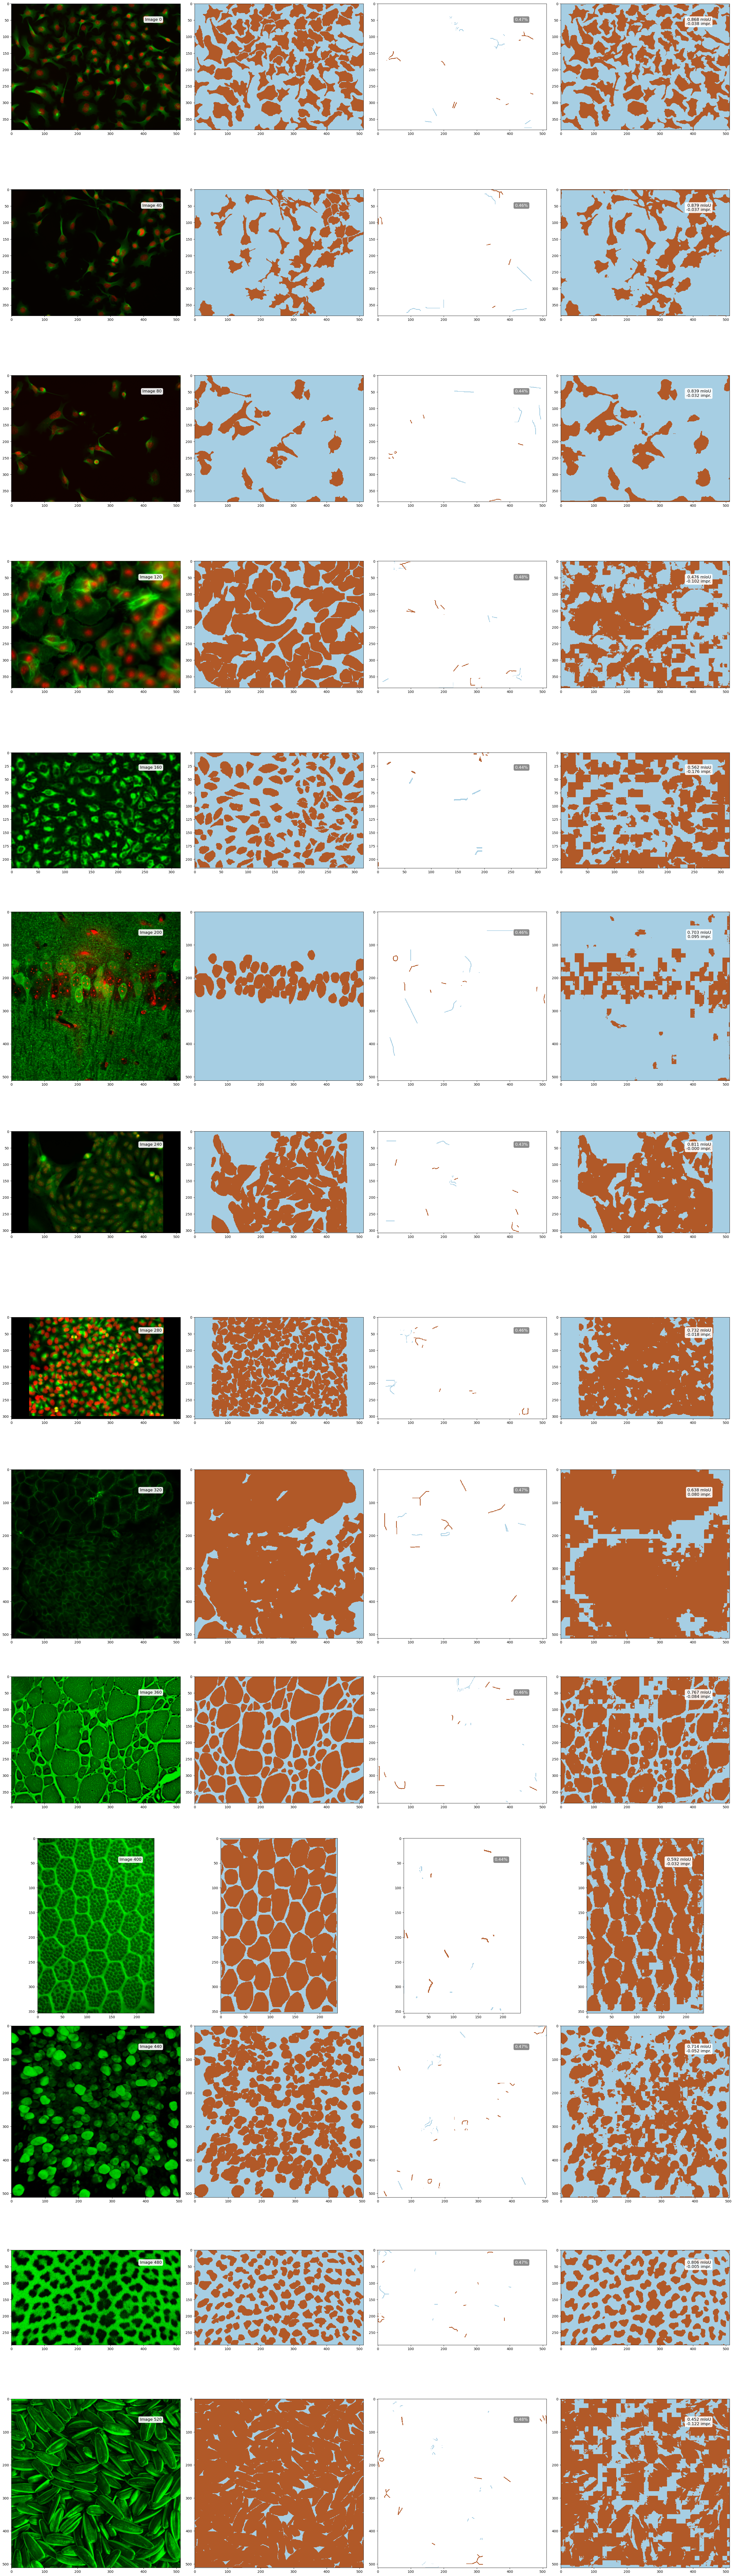

In [53]:
df_list = []
labels_list = []
pred_list = []

# old_df = pd.read_csv("../FoodSeg103_results/food_run06a_240531101713_processed.csv")
# old_df = pd.read_csv("../FoodSeg103_results/food_run07_240711113239_processed.csv")
old_df = pd.read_csv("../cellpose_results/cellpose_run07_240712134610_processed.csv")

num_imgs = len(imgs)
tot_h = sum([im.shape[0] for im in imgs.values()])
tot_w = 4 * max([im.shape[1] for im in imgs.values()])
fig, ax = plt.subplots(num_imgs, 4, figsize=(30, 40/tot_w*tot_h), dpi=100)
plt.tight_layout()
c_map = 'Paired'
i = 0

for img_num, img in imgs.items():
    gt = gts[img_num]
    img = img/255
    print(f"Image number: {img_num}")

    np.random.seed(scribbles_seed)
    labels = create_even_scribbles(gt, max_perc=bin, rel_scribble_len=rel_scribble_len, scribble_width=scribble_width, mode=mode, enforce_max_perc=enforce_max_perc, print_steps=False)
    labels_list.append(labels)
    # labels = labels_list[i]

    # pred = selfpredict_segforest_single_image(img, labels, get_vgg16_feature_space, vgg16_cfg, random_state=pred_seed)
    pred = selfpredict_segforest_single_image(img, labels, features_combinator, combinator_cfg, random_state=pred_seed)
    pred_list.append(pred)
    # pred = pred_list[i]

    perc_labelled = np.sum(labels>0) / labels.size * 100
    macc, mprecision, mrecall, mIoU, mF1 = single_img_stats(gt, pred)
    old_mIoU = old_df[(old_df["scribbles bin"] == bin) &
                      (old_df["img_num"] == img_num) &
                      (old_df["prediction tag"] == pred_tag)]["mIoU"]
    old_mIoU = old_mIoU.values[0]
    mIoU_improvement = mIoU - old_mIoU
    stats = {"img_num": img_num, "bin": bin, "percent labelled": perc_labelled, "scribble_width": scribble_width, "mode": mode, "macc": macc, "mprecision": mprecision, "mrecall": mrecall, "mIoU": mIoU, "mF1": mF1, "old_mIoU": old_mIoU, "mIoU_improvement": mIoU_improvement}
    df_list.append(pd.DataFrame(stats, index=[0]))
    
    ax[i, 0].imshow(img)
    ax[i, 0].text(img.shape[1]*8/9, img.shape[0]/9, s=f"Image {img_num}", fontsize="large", bbox={"boxstyle":"Round", "color":"white", "alpha":0.9}, ha="right", va="top")
    ax[i, 1].imshow(gt, cmap=c_map, interpolation="none")
    mask = labels!=0
    masked_labels = np.ma.masked_where(~mask, labels)
    ax[i, 2].imshow(masked_labels, cmap=c_map, interpolation="none")
    ax[i, 2].text(img.shape[1]*8/9, img.shape[0]/9, f"{perc_labelled:.2f}%", fontsize="large", color="white", bbox={"boxstyle":"Round", "color":"grey", "alpha":0.9}, ha="right", va="top")
    ax[i, 3].imshow(pred, cmap=c_map, interpolation="none")
    ax[i, 3].text(img.shape[1]*8/9, img.shape[0]/9, s=f"{mIoU:.3f} mIoU\n{mIoU_improvement:.3f} impr.", fontsize="large", bbox={"boxstyle":"Round", "color":"white", "alpha":0.9}, ha="right", va="top")
    i+=1

df = pd.concat(df_list, ignore_index=True)

In [ ]:
plt.savefig("FoodSeg_improvement_seghub003_01.png", dpi=300)

In [114]:
df.to_csv("FoodSeg_improvement_seghub003_01.csv", index=False)

# TEST NEW FUNCTIONS

In [4]:
img = imgs[0]
gt = gts[0]
labels = create_even_scribbles(gt, max_perc=0.5, scribble_width=2, rel_scribble_len=10, mode="all", enforce_max_perc=True, print_steps=False)

In [13]:
rf = train_segforest([img], [labels], get_vgg16_feature_space, features_cfg, random_state=123)

In [14]:
pred = predict_segforest_single_image(img, rf, get_vgg16_feature_space, features_cfg)

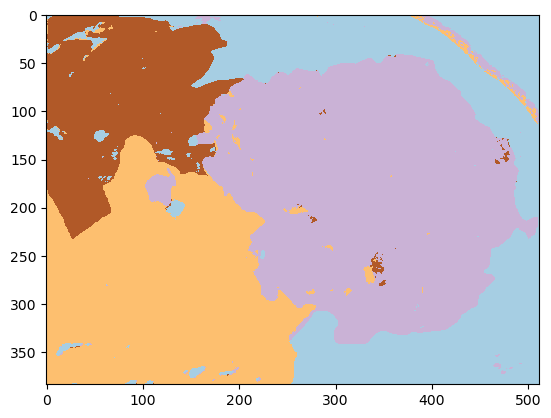

In [15]:
plt.imshow(pred, cmap='Paired', interpolation='none')

In [26]:
self_pred = selfpredict_segforest_single_image(img, labels, get_vgg16_feature_space, features_cfg)

(875, 128) (875,)
